<h1 style="font-family:Times New Roman; font-size: 300%"><center>FYS5429 Spring 2025 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">2-Dimensional Quantum dots</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We first import packages, define notebook parameters and define functions
</p>

In [1]:
import numpy as np
import math
from math import factorial, sqrt, pi
from scipy.integrate import simps
import torch
import functorch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import os
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
    
from Config import PARAMS

In [2]:
PARAMS["n_particles"] = 2
PARAMS["omega"] = 0.5
PARAMS["nx"] = 1
PARAMS["nx"] = 1
PARAMS["E"] = 1.65977
PARAMS["n_epochs"] = 5000
PARAMS["N_collocation"] = 1000
PARAMS["L"]=3
PARAMS["L_E"]=4

In [3]:
from master_functions import *
from PINN import PINN
torch.set_num_threads(1)
locals().update(PARAMS)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Initializing Slater determinant</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We do not include any interaction or correlation in our slater determinant, and therefore only fill up the quantum states according to Pauli's exclusion principle.
</p>

In [4]:
xgrid = np.linspace(-L, L, n_grid)
ygrid = np.linspace(-L, L, n_grid)
n_electrons = n_particles      # Two electrons, occupying the same spatial orbital (opposite spins)

# 1) Build the 2D harmonic oscillator basis
basis_2d = initialize_harmonic_basis_2d(nx, ny, xgrid, ygrid,omega)
n_basis = basis_2d.shape[1]
print(f"2D Basis: n_points = {basis_2d.shape[0]}, n_basis = {n_basis}")

# 2) Compute one-electron integrals in 2D
print("Computing one-electron integrals (Hcore)...")
Hcore_2d = one_electron_integral_2d(basis_2d, xgrid, ygrid,omega)
print("One-electron integrals computed.")

# 3) Build the 2D Gaussian interaction potential
V_SD = 0.0     # Interaction strength
sigma = 0.5  # Gaussian width
print("Building 2D Gaussian interaction matrix...")
V_interaction_2d = gaussian_interaction_potential_2d(xgrid, ygrid, V_SD, sigma)

# 4) Compute two-electron integrals in 2D
print("Computing two-electron integrals...")
two_body_2d = compute_two_body_integrals_2d(basis_2d, V_interaction_2d, xgrid, ygrid)
print("Two-electron integrals computed.")

# 5) Run closed-shell Hartree-Fock for 2 electrons in the ground state
print("Starting closed-shell Hartree-Fock iterations...")
C_occ, orbital_energies = hartree_fock_2d(n_electrons, basis_2d, xgrid, ygrid,
                                          Hcore_2d, two_body_2d)
print("Occupied Orbital Energies:", orbital_energies)
C_occ = torch.Tensor(C_occ)
C_occ

2D Basis: n_points = 900, n_basis = 1
Computing one-electron integrals (Hcore)...
One-electron integrals computed.
Building 2D Gaussian interaction matrix...
Computing two-electron integrals...
Computing integrals for basis p=0
Two-electron integrals computed.
Starting closed-shell Hartree-Fock iterations...
Iteration 0: ΔD = 0.000e+00
Final HF Energy = 1.006685
Occupied Orbital Energies: [0.50334243]


tensor([[1.]])

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Initializing and training PINN</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We are now ready to train our PINN, with an initialized Slater determinant and notebook parameters
</p>

In [32]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=hidden_dim, n_layers=3, act=nn.GELU(),init='custom').to(device) #3 hidden layers

In [33]:
optimizer = optim.Adam(f_net.parameters(), lr=1e-3)
f_net, _ = train_model(V, E, f_net, optimizer,C_occ,std=1.3,factor=0.0) #Training with weak normalization term

Epoch 00000: PDE Loss = 3.437e-03,Norm = 1.861e+00,  Variance = 1.624e+00
Epoch 00050: PDE Loss = 2.740e-05,Norm = 1.341e+00,  Variance = 3.910e-02
Epoch 00100: PDE Loss = 1.205e-06,Norm = 1.062e+00,  Variance = 8.260e-03
Epoch 00150: PDE Loss = 4.336e-04,Norm = 1.492e+00,  Variance = 2.130e+00
Epoch 00200: PDE Loss = 1.386e-05,Norm = 9.335e-01,  Variance = 2.406e-02
Epoch 00250: PDE Loss = 4.782e-06,Norm = 9.792e-01,  Variance = 1.066e-02
Epoch 00300: PDE Loss = 1.768e-06,Norm = 1.021e+00,  Variance = 5.493e-03
Epoch 00350: PDE Loss = 7.368e-05,Norm = 9.995e-01,  Variance = 2.161e-01
Epoch 00400: PDE Loss = 1.207e-06,Norm = 1.018e+00,  Variance = 3.976e-03
Epoch 00450: PDE Loss = 8.945e-07,Norm = 1.007e+00,  Variance = 3.138e-03
Epoch 00500: PDE Loss = 5.249e-07,Norm = 1.023e+00,  Variance = 2.796e-03


KeyboardInterrupt: 

In [20]:
# Assume `model` is your nn.Module
save_path = "2p_0.5.pth"
torch.save(f_net.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to 2p_0.5.pth


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Validating results</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We are now ready to plot the final results and calculate the corresponding energy
</p>

In [34]:
def construct_grid_configurations(n_particles, dims, Ngrid, L, device="cpu"):
    """
    Constructs configurations on a 2D grid for a system with n_particles (each with dims=2),
    where the first electron's position is varied over a grid on [-L,L]^2 and all
    the remaining electrons are fixed at (0, 0).
    
    Args:
        n_particles (int): Total number of electrons.
        dims (int): Dimension per electron (should be 2).
        Ngrid (int): Number of grid points per coordinate.
        L (float): Range for the grid (each coordinate in [-L,L]).
        device (str): Device to use.
    
    Returns:
        x_configs (torch.Tensor): Tensor of shape (Ngrid*Ngrid, n_particles, dims).
        X (np.ndarray), Y (np.ndarray): Meshgrid arrays for electron 0's x and y coordinates (bin edges).
    """
    assert dims == 2, "This function is designed for a 2D system (dims must be 2)."
    
    # Create a 1D grid for electron 0's x and y coordinates.
    x_vals = torch.linspace(-L, L, Ngrid, device=device)
    y_vals = torch.linspace(-L, L, Ngrid, device=device)
    # Meshgrid over electron 0's coordinates.
    X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')  # Each of shape (Ngrid, Ngrid)
    
    # Flatten to get a list of positions for electron 0: shape (Ngrid*Ngrid, 2)
    e0_coords = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)  # (Ngrid*Ngrid, 2)
    
    # For the remaining electrons, fix them at (0,0) (or any reference point you choose).
    fixed_pos = torch.zeros(n_particles - 1, dims, device=device)  # shape: (n_particles-1, 2)
    
    # Repeat e0_coords for each grid point: we want shape (Ngrid*Ngrid, n_particles, 2)
    # The first electron gets e0_coords, and the others get fixed_pos.
    N_total = e0_coords.shape[0]
    # Expand e0_coords to shape (N_total, 1, 2)
    e0_coords_expanded = e0_coords.unsqueeze(1)
    # Expand fixed_pos to shape (1, n_particles-1, 2) and then repeat for each grid point.
    others_expanded = fixed_pos.unsqueeze(0).expand(N_total, -1, -1)
    
    # Concatenate along the particle dimension.
    x_configs = torch.cat([e0_coords_expanded, others_expanded], dim=1)
    # x_configs shape: (Ngrid*Ngrid, n_particles, 2)
    return x_configs, X.detach().cpu().numpy(), Y.detach().cpu().numpy()

def plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device="cpu"):
    """
    Evaluate psi_fn on a grid and plot |Ψ|^2 as a heatmap.
    
    Here, psi_fn is expected to take input x of shape (Ngrid*Ngrid, n_particles, dims)
    and return a tensor of shape (Ngrid*Ngrid, 1). The plot is made with respect to the
    x-y coordinates of electron 0.
    
    Args:
        psi_fn (callable): Function computing Ψ(x) for x of shape (batch, n_particles, 2).
        n_particles (int): Total number of electrons.
        Ngrid (int): Number of grid points per coordinate.
        L (float): Range for the grid (each coordinate in [-L,L]).
        device (str): Device.
    """
    # Construct configurations on the grid.
    x_configs, X, Y = construct_grid_configurations(n_particles, 2, Ngrid, L, device)
    # Evaluate wavefunction.
    psi_vals = psi_fn(f_net, x_configs, C_occ).detach()  # shape: (Ngrid*Ngrid, 1)
    density = psi_vals.abs() ** 2  # (Ngrid*Ngrid, 1)
    
    # Reshape density into a 2D array for electron 0's grid.
    density_grid = density.view(Ngrid, Ngrid).cpu().numpy()
    
    # Plot the heatmap.
    plt.figure(figsize=(12,9))
    plt.pcolormesh(X, Y, density_grid, cmap=thesis_viridial)
    plt.xlabel("x coordinate (electron 0)")
    plt.ylabel("y coordinate (electron 0)")
    plt.title("Wavefunction Density Heatmap")
    plt.colorbar(label="|Ψ(x)|²")
    plt.show()

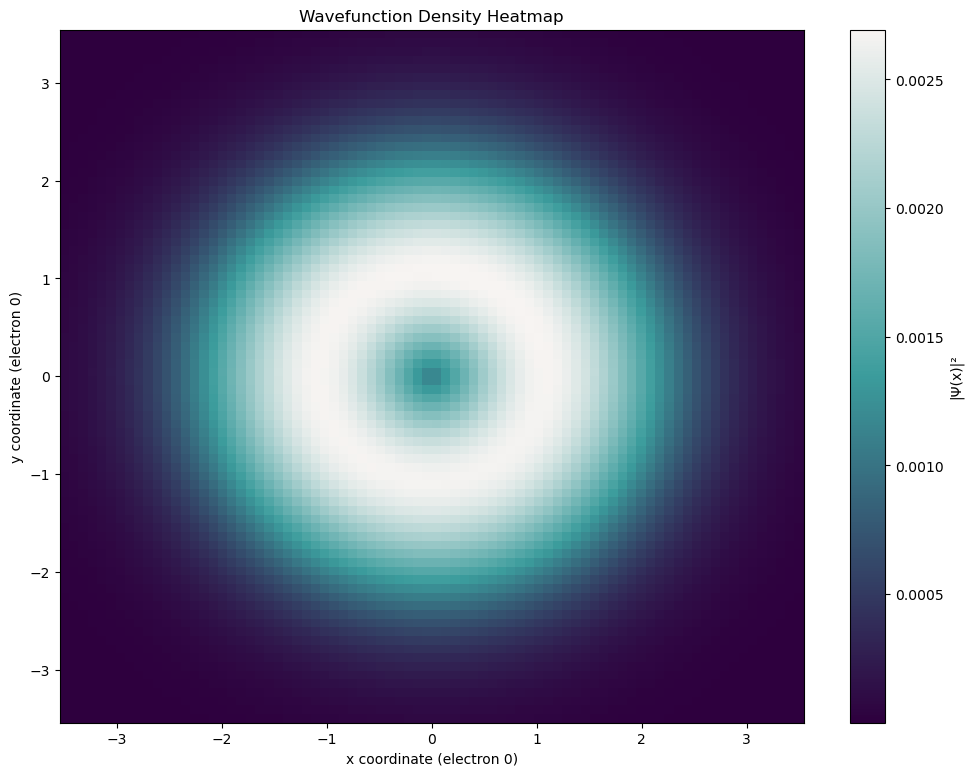

In [35]:
from matplotlib.colors import LinearSegmentedColormap
thesis_viridial = LinearSegmentedColormap.from_list("thesis_viridial", [
    "#2e003e",  # deep violet
    "#3b9c9c",  # dusty teal
    "#f7f4f2",  # ivory white
], N=256)

# --- Example usage ---
if __name__ == '__main__':
    device = "cpu"
    n_particles = 2   # e.g., for a two-electron system
    Ngrid = 80        # Grid resolution per coordinate.
    L = 3.5           # Grid ranges: [-3, 3] for x and y.
    
    plot_wavefunction_heatmap(psi_fn, n_particles, Ngrid, L, device)


In [36]:
_idx_i, _idx_j = torch.triu_indices(n_particles, n_particles, offset=1)
_idx_i=_idx_i.to("cpu")
_idx_j=_idx_j.to("cpu")

def compute_coulomb(x, V_val=1.0):
    """
    x: Tensor of shape (batch, n_particles, dim)
    V_val: scalar prefactor
    returns: Tensor of shape (batch,) giving \sum_{i<j} V_val / |x_i - x_j|
    """
    # Gather the i,j coordinates: each is (batch, npairs, dim)
    xi = x[:,_idx_i, :]  
    xj = x[:,_idx_j, :]

    # Compute pairwise distances (batch, npairs)
    #rij = (xi - xj).norm(dim=-1).clamp_min(1e-7)
    rij = torch.norm(xi - xj,dim=-1) + 1e-20
    # Sum V_val / r over all unique pairs
    return (V_val / rij).sum()
    
def compute_laplacian_fast(psi_fn, f_net, x, C_occ):
    """
    Exact Laplacian via nested torch.autograd.grad calls.

    Args:
      psi_fn : callable(f_net, x_batch, C_occ, nx, ny) -> psi of shape (batch,)
      f_net  : your neural network
      x      : Tensor (batch, n_particles, d) with requires_grad=True
      C_occ, nx, ny : parameters for slater_determinant_closed_shell

    Returns:
      lap : Tensor of shape (batch, 1), containing ∇²ψ for each sample.
    """
    # ensure we have a fresh graph on x
    x = x.requires_grad_(True)
    batch, n, d = x.shape

    # 1) compute psi (batch,)
    Psi = psi_fn(f_net, x, C_occ)
    psi=Psi#.squeeze()
    # 2) first derivatives ∂ψ/∂x  -> shape (batch, n, d)
    grads = torch.autograd.grad(
        psi.sum(), x, create_graph=True
    )[0]

    # 3) accumulate second derivatives per coordinate
    lap = torch.zeros(batch, device=x.device)
    for i in range(n):
        for j in range(d):
            # sum over batch to get scalar for this coordinate
            g_ij = grads[:, i, j].sum()
            # second derivative ∂²ψ/∂x_{i,j}²
            second = torch.autograd.grad(
                g_ij, x, create_graph=True
            )[0]
            # add the diagonal piece
            lap = lap + second[:, i, j]

    return Psi, lap.unsqueeze(1)  # shape (batch,1)
import torch
from torch.func import jacfwd, jacrev
from tqdm import tqdm

def blocking_error(data: torch.Tensor) -> float:
    """
    Estimate the standard error of the mean via recursive blocking.
    data: 1D tensor of length N (the sampled energies).
    Returns: estimated standard error (a Python float).
    """
    x = data.clone().detach().double().cpu().numpy()

    N = x.size
    if N < 2:
        return 0.0

    variances = []
    
    while N > 1:
        var = np.var(x, ddof=1) / N  # variance of mean estimate
        variances.append(var)

        N = N // 2
        # Apply blocking by averaging adjacent pairs
        x = 0.5 * (x[0:2*N:2] + x[1:2*N:2])  # length now N
    
    # Return square root of the final variance estimate
    return float(np.sqrt(variances[-1]))

class PINNSampler:
    def __init__(self, f_net, psi_fn, N, d, omega=1.0, step_size=0.5, C_occ=C_occ):
        """
        f_net: neural net model
        psi_fn: function f(f_net, x, C_occ) -> psi(x)
        N: number of particles
        d: dimension per particle
        omega: harmonic oscillator frequency
        step_size: Metropolis step size
        C_occ: orbital coefficient matrix (torch.Tensor)
        """
        self.f_net = f_net
        self.psi_fn = psi_fn
        self.N = N
        self.d = d
        self.omega = omega
        self.step_size = step_size

        # Device and dtype from network
        param = next(f_net.parameters())
        #param.device="cpu"
        self.device = "cpu"#param.device
        self.dtype = param.dtype
        self.f_net.eval()
        self.f_net.to(self.device)
        for p in self.f_net.parameters():
            p.requires_grad_(False)

        # Ensure C_occ is correct
        assert C_occ is not None, "C_occ must be provided"
        if C_occ.device != self.device or C_occ.dtype != self.dtype:
            self.C_occ = C_occ.to(device=self.device, dtype=self.dtype)
        else:
            self.C_occ = C_occ

    def propose(self, x, ψ_old):
        """Propose a new configuration for a single particle."""
        x_prop = x.clone()
        i = torch.randint(self.N, (1,), device=x.device).item()
        move = torch.randn(self.d, dtype=self.dtype, device=self.device) * self.step_size
        x_prop[i] += move

        ψ_new = self.psi_fn(self.f_net.eval(), x_prop.unsqueeze(0), self.C_occ)  # shape: (1,1)
        ratio = (ψ_new / ψ_old).square()

        accept = torch.rand(1, device=x.device) < ratio
        return (x_prop if accept else x), (ψ_new if accept else ψ_old), accept.item()

    def local_energy(self, x):
        """Compute local energy E_L = -½ ∇²ψ/ψ + V_harm + V_int"""
        xb = x.unsqueeze(0)
        ψ, lap = compute_laplacian_fast(self.psi_fn, self.f_net.eval(), xb, self.C_occ)

        # Avoid .item() in tight loop
        kinetic = (-0.5 * lap / ψ).squeeze()
        V_harm = 0.5 * self.omega**2 * (x**2).sum()
        V_int = compute_coulomb(xb)  # this returns scalar

        return (kinetic + V_harm + V_int).detach()

    def sample(self, n_samples, n_burnin=100):
        """Run Metropolis-Hastings sampling with proper caching."""
        self.f_net.zero_grad(set_to_none=True)
        f_net.to(torch.float).eval()
        # Initial walker
        x = 0.1 * torch.randn((self.N, self.d), dtype=self.dtype, device=self.device)
        ψ_old = self.psi_fn(self.f_net.eval(), x.unsqueeze(0), self.C_occ)
        accepted = 0
        energies = []

        # Burn-in
        for _ in tqdm(range(n_burnin), desc="Burn-in"):
            x, ψ_old, _ = self.propose(x, ψ_old)

        # Sampling
        for _ in tqdm(range(n_samples), desc="Sampling"):
            x, ψ_old, acc = self.propose(x, ψ_old)
            accepted += acc
            E = self.local_energy(x)
            energies.append(E)
        
        energies = torch.stack(energies).double().cpu()
        acc_rate = accepted / n_samples
        err = blocking_error(energies)

        return energies, acc_rate, err


In [37]:
f_net.to("cpu")
f_net.to(torch.float).eval()

sampler = PINNSampler(f_net, psi_fn, N=2, d=2, omega=0.5, step_size=0.5)

# Draw 500 samples after 200 burn-in steps
energies, acc_rate, err = sampler.sample(n_samples=10000, n_burnin=400)

print(f"⟨E_loc⟩ = {energies.mean().item():.6f} ± {err:.6f}")
print(f"Acceptance rate = {acc_rate:.2f}")


Sampling: 100%|██████████████████████████| 10000/10000 [01:33<00:00, 107.07it/s]

⟨E_loc⟩ = 1.657326 ± 0.000416
Acceptance rate = 0.79
